In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from python import prepare_inputs as pi
from python import solar_utils as su
from python import wind_utils as wu
from python import hydro_utils as hu
from python import utils as pu

from python.utils import project_path
from python.building_elec_model import building_types_dict

# Input data for a run

In [2]:
# Read GenX
df_genX = pd.read_csv(f'{project_path}/data/genX/capacity_Low_RE_High_Elec.csv')
df_genX = pi.tidy_genX(df_genX).query('EndCap > 1.')

In [3]:
df_genX.groupby('Resource')['EndCap'].sum()

Resource
battery                    5999.830098
biomass                     113.100000
distributed_generation     2553.999939
hydroelectric              4357.000000
hydroelectric_storage      1406.700000
natural_gas               16458.799831
nuclear                    2699.998583
offshore_wind              5737.998789
onshore_wind_existing      3388.999992
solar_existing             1706.399995
solar_new                 23133.293921
transportation             3407.100000
water_heating               139.100000
Name: EndCap, dtype: float64

In [4]:
df_genX.groupby('Resource')['EndCap'].sum().sum()

np.float64(71102.32114817739)

In [5]:
df_genX.groupby('Resource')['StartEnergyCap'].sum()

Resource
battery                       0.0
biomass                       0.0
distributed_generation        0.0
hydroelectric                 0.0
hydroelectric_storage     21803.8
natural_gas                   0.0
nuclear                       0.0
offshore_wind                 0.0
onshore_wind_existing         0.0
solar_existing                0.0
solar_new                     0.0
transportation                0.0
water_heating                 0.0
Name: StartEnergyCap, dtype: float64

In [6]:
# Read GenX downscaled
df_genX_ds = pd.read_csv(f'{project_path}/data/genX/selected_CPA_Combined_Capacity_Low_RE_High_Elec.csv')

df_genX_ds = (df_genX_ds[(df_genX_ds['state'] == 'New York') & (df_genX_ds['iter'] == 0)]
              .drop_duplicates(subset=['Resource', 'Zone'], keep='first')
              .query('EndCap > 1.')
             )

df_genX_ds.groupby('Resource_Type')['EndCap'].sum()

Resource_Type
Utility_PV    23133.29392
Name: EndCap, dtype: float64

In [7]:
# Run name (make sure matches above!)
run_name = "low_RE_high_elec_iter0_defaultsubset"

run_path = f"{project_path}/runs/{run_name}"

Path(f"{run_path}/inputs").mkdir(parents=True, exist_ok=True)
Path(f"{run_path}/outputs").mkdir(parents=True, exist_ok=True)

In [8]:
# Read ACORN generators
df_genprop_bo = pd.read_csv(f'{project_path}/data/grid/gen_prop_boyuan.csv')
df_gencost_bo = pd.read_csv(f'{project_path}/data/grid/gencost_prop_boyuan.csv')

# Merge costs and info
df_genprop = pd.merge(df_gencost_bo, df_genprop_bo)

# Select NYS only
df_genprop = df_genprop[df_genprop['GEN_ZONE'].isin(pu.zone_names)]

### Storage

In [9]:
# Generate random sites per zone
df_genX_battery = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'battery'].copy(), genX_zone_col='Zone')
df_genX_battery = pi.generate_random_sites(df_genX_battery,
                                           sites_per_zone = 3,
                                           columns_to_scale = ['EndEnergyCap', 'EndCap'])

In [10]:
# Assign to random bus
df_genX_battery = pu.nearest_neighbor_lat_lon(df_genX_battery, PV_bus_only=False)

In [11]:
# Store
(
    df_genX_battery[['bus_id', 'EndCap', 'EndEnergyCap']]
    .groupby('bus_id').sum()
     .rename(columns={'EndCap':'charge_capacity_MW', 
                      'EndEnergyCap':'storage_capacity_mwh'})
     .to_csv(f"{run_path}/inputs/storage_assignment.csv")
)

### Thermal

In [12]:
# Match thermal capacities (natural gas only)
df_ng_matched = pi.match_ng_capacity(df_genX,
                                     df_genprop,
                                     store_path = run_path,
                                     retirement_method='highest_cost_first')

Starting capacity matching process...

Capacity comparison:
Zone | Current (MW) | Target (MW) | Difference (MW)
-------------------------------------------------------
A    |       393.0 |      536.8 |         143.8
Zone A: Added 4 duplicate generators, increasing capacity by 189.0 MW (target: 143.8 MW)
B    |       109.0 |      269.1 |         160.1
Zone B: Added 3 duplicate generators, increasing capacity by 198.0 MW (target: 160.1 MW)
C    |      1709.0 |     1672.9 |         -36.1
Zone C: Retired 1 generators, reducing capacity by 110.0 MW (target: 36.1 MW)
D    |       346.0 |      371.0 |          25.0
Zone D: Added 1 duplicate generators, increasing capacity by 153.0 MW (target: 25.0 MW)
E    |       206.0 |      201.6 |          -4.4
Zone E: Retired 1 generators, reducing capacity by 45.0 MW (target: 4.4 MW)
F    |      3159.0 |     3797.5 |         638.5
Zone F: Added 2 duplicate generators, increasing capacity by 711.0 MW (target: 638.5 MW)
G    |      1761.0 |     2015.0 |  

In [13]:
# Store with only online generators
df_ng_matched = df_ng_matched[df_ng_matched['GEN_STATUS'] == 1].copy()
df_ng_matched.to_csv(f"{run_path}/inputs/genprop_ng_matched.csv", index=False)

### Nuclear

In [14]:
# GenX
df_genX.query('Resource == "nuclear"')[['Resource', 'Zone', 'EndCap']]

,Resource,Zone,EndCap
178,nuclear,C&E,2699.998583


In [15]:
# ACORN
df_genprop[df_genprop['FUEL_TYPE'] == 'UR'][['GEN_NAME', 'PMAX', 'GEN_ZONE', 'GEN_STATUS']]

,GEN_NAME,PMAX,GEN_ZONE,GEN_STATUS
236,Indian Point 2,1026.5,H,1
237,Indian Point 3,1040.4,H,1
238,James A. FitzPatrick,858.9,C,1
239,Nine Mile Point 1,630.5,C,1
240,Nine Mile Point 2,1246.6,C,1
241,R. E. Ginna,582.0,B,1


In [16]:
# Match nuclear by hand -> keep only nuclear in zone C
# Retire all nuclear outside zone C
df_genprop_nuclear = df_genprop[(df_genprop['FUEL_TYPE'] == 'UR') & (df_genprop['GEN_ZONE'] == 'C')]
# Store
df_genprop_nuclear.to_csv(f"{run_path}/inputs/genprop_nuclear_matched.csv", index=False)

### Hydro

In [17]:
# First store the hydro generators
large_hydro_names = ['Moses Niagara (Fleet)', 'St Lawrence - FDR (Fleet)']

df_genprop_hydro = df_genprop[df_genprop['GEN_NAME'].isin(large_hydro_names)]
df_genprop_hydro.to_csv(f"{run_path}/inputs/genprop_hydro.csv", index=False)

In [18]:
# Get hourly hydro to buses
hydro_scenario = 'historical'
df_small_hydro, df_large_hydro = hu.assign_hydro_GD_to_buses(hydro_scenario = hydro_scenario)

In [19]:
# Store
df_small_hydro.reset_index().pivot(index='bus_id', 
                                   columns='datetime', 
                                   values='power_MW').to_csv(f"{run_path}/inputs/small_hydro_{hydro_scenario}.csv")

df_large_hydro.reset_index().pivot(index='bus_id', 
                                   columns='datetime', 
                                   values='power_predicted_mwh').to_csv(f"{run_path}/inputs/large_hydro_{hydro_scenario}.csv")

### Solar

In [ ]:
#######################
# Existing solar: DPV
#######################
# Generate existing onshore sites
df_genX_solar_dpv = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'distributed_generation'].copy(),
                                               genX_zone_col='Zone')

df_genX_solar_dpv = pi.generate_random_sites(df_genX_solar_dpv, sites_per_zone=10)

## TGW climate data
climate_scenario = "historical_1980_2019"

# All
climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))

# # Subset
# climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
#                           for year in range(1982, 1983)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_dpv = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_solar_dpv,
    climate_paths = climate_paths,
    correction_file = correction_file,
    PV_bus_only = False
)

# Store
df_solar_dpv.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_dpv_{climate_scenario}.csv")

In [ ]:
######################
# Existing solar: UPV
######################
# Generate existing sites
df_genX_solar_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'solar_existing'].copy(),
                                                   genX_zone_col='Zone')

df_genX_solar_existing = pi.generate_random_sites(df_genX_solar_existing, sites_per_zone=1)

# TGW climate data
climate_scenario = "historical_1980_2019"

# All
climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))

# # Subset
# climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
#                           for year in range(1982, 1983)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_existing = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_solar_existing,
    climate_paths = climate_paths,
    correction_file = correction_file,
)

In [ ]:
################################################################
# NOTE: The genX zones do not always align with their coordinates
# (i.e. they will be assigned to a different zone).
# When aggregating to bus level, assigning `match_zone` = True
# means that genX zones will be respected. `match_zone` = False
# means it will use the lat/lon coords instead.
################################################################
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# Plot
fig, axs = plt.subplots(1,2, figsize=(15,10))

nyiso_gdf.plot(ax=axs[0])
pu.merge_to_zones(df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'],
               lat_name='latitude',
               lon_name='longitude').plot(ax=axs[0], column='region', legend=True, cmap='Paired')

nyiso_gdf.plot(ax=axs[1], column='zone', legend=True, cmap='Paired')

plt.show()

In [ ]:
####################
# New solar
####################
# Update the genX regions
df_genX_ds_solar = df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'].copy()
df_genX_ds_solar = pu.map_genX_zones_to_nyiso(df_genX_ds_solar, C_and_E_mapping='C')

# TGW climate data
climate_scenario = "historical_1980_2019"

# All
climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))

# # Subset
# climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
#                           for year in range(1982, 1983)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_new = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_ds_solar,
    climate_paths = climate_paths,
    correction_file = correction_file,
)

In [ ]:
# Combined solar
df_solar_total = pd.concat([df_solar_existing, df_solar_new])
df_solar_total = df_solar_total.reset_index().groupby(['bus_id', 'datetime']).sum()

# Store combined
df_solar_total.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_upv_{climate_scenario}.csv")

### Wind

In [ ]:
########################
# Existing onshore wind
########################
# Generate existing onshore sites
df_genX_onshore_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'onshore_wind_existing'].copy(),
                                                      genX_zone_col='Zone')

df_genX_onshore_existing = wu.generate_onshore_wind_sites(df_genX_onshore_existing)

# TGW climate data
climate_scenario = "historical_1980_2019"

climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))

# climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
#                           for year in range(1982, 1983)]).flatten()

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/wind/models/tgw_wind_stability_coefficients_2007-2007_every100.csv"

# Calculate the timeseries
df_onshore_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_onshore_existing,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'iec1',
)

In [ ]:
########################
# Existing offshore wind
########################
### Generate sites
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# Generate offshore locations
df_genX_offshore_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'offshore_wind'].copy(),
                                                      genX_zone_col='Zone')

df_genX_offshore_existing = wu.generate_offshore_wind_sites(df_genX_offshore_existing)

# Check
fig, ax = plt.subplots()
nyiso_gdf[nyiso_gdf['zone'].isin(df_genX_offshore_existing['genX_zone'].unique())].plot(ax=ax)
df_genX_offshore_existing.plot(ax=ax, color='orange')
plt.show()

# Generate timeseries
# TGW climate data
climate_scenario = "historical_1980_2019"

climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
# climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
#                           for year in range(1982, 1983)]).flatten()

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/wind/models/tgw_wind_stability_coefficients_2007-2007_every100.csv"

# Calculate the timeseries
df_offshore_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_offshore_existing,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'offshore',
)

In [ ]:
# Combined wind
df_wind_total = pd.concat([df_onshore_wind, df_offshore_wind])
df_wind_total = df_wind_total.reset_index().groupby(['bus_id', 'datetime']).sum()

# Store combined
df_wind_total.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/wind_{climate_scenario}.csv")

### Load

In [ ]:
# Settings
climate_scenario = "historical_1980_2019"

In [ ]:
# Read baseline
df_baseline = pd.read_parquet(f"../data/load/baseline/simulated/load_model_tgw_multizone_NN_{climate_scenario}.parquet")
df_baseline = df_baseline.groupby(['bus_id', 'datetime'])[['load_MW']].sum(numeric_only=True)

In [ ]:
# Read ResStock
upgrade = 1
df_resstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/resstock/simulated/bus_level/{climate_scenario}_{upgrade}_{home_type}.parquet") for home_type in building_types_dict['resstock']])
df_resstock = df_resstock.reset_index()
df_resstock = df_resstock.groupby(['bus_id','time']).sum()

In [ ]:
# Read ComStock
upgrade = 31
df_comstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/comstock/simulated/bus_level/{climate_scenario}_{upgrade}_{home_type}.parquet") for home_type in building_types_dict['comstock']])
df_comstock = df_comstock.reset_index()
df_comstock = df_comstock.groupby(['bus_id','time']).sum()

In [22]:
# Combine
df_load = pd.concat([df_comstock.reset_index().rename(columns={'bus_load_MW':'load_MW', 'time':'datetime'}),
                     df_resstock.reset_index().rename(columns={'bus_load_MW':'load_MW', 'time':'datetime'}),
                     df_baseline.reset_index()]).groupby(['bus_id', 'datetime']).sum()

<Axes: xlabel='datetime'>

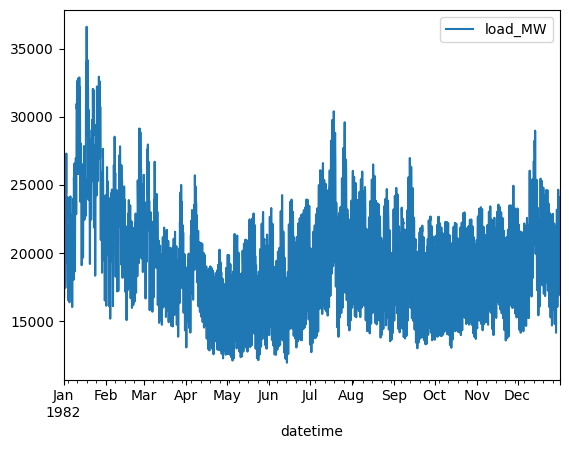

In [23]:
df_load.groupby('datetime').sum().plot()

In [24]:
# Store
df_load.reset_index().pivot(index='bus_id', 
                            columns='datetime', 
                            values='load_MW').to_csv(f"{run_path}/inputs/load_{climate_scenario}.csv")